TIFF shape: (161, 1024, 1024)
✅ Mask (≥3× change) saved to: /Users/lokesh.pimpale/Desktop/work_dir/RK/RK25DE14A-D28_Stream_C08_s1_t1_FITC-1_mask_largest_dynamic3x.tif
✅ Frame-of-50%-max map saved to: /Users/lokesh.pimpale/Desktop/work_dir/RK/RK25DE14A-D28_Stream_C08_s1_t1_FITC-1_frame50map_dynamic3x.tif


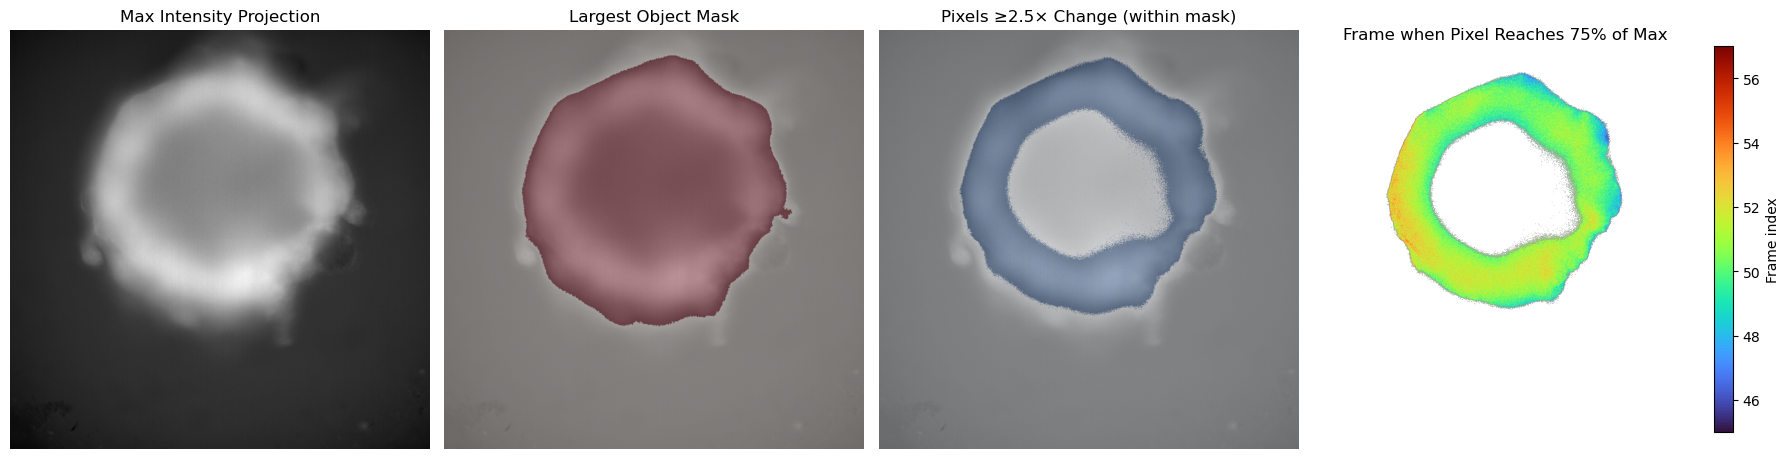

In [1]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import measure, morphology, filters
import os

# === INPUT ===
#tif_path = "/Users/lokesh.pimpale/Desktop/work_dir/RK/RK25DE14A-D28_Stream_D22_s1_t1_FITC-1.tif"
tif_path = "/Users/lokesh.pimpale/Desktop/work_dir/RK/RK25DE14A-D28_Stream_C08_s1_t1_FITC-1.tif"

# === LOAD TIFF ===
data = tiff.imread(tif_path)  # shape: (frames, height, width)
print("TIFF shape:", data.shape)
data = data.astype(np.float32)

# === STEP 1: MAX INTENSITY PROJECTION ===
mip = np.max(data, axis=0)

# === STEP 2: SEGMENT LARGEST OBJECT ===
thresh = filters.threshold_otsu(mip)
binary = mip > thresh
binary_filled = ndi.binary_fill_holes(binary)
binary_clean = morphology.remove_small_objects(binary_filled, min_size=500)
labels = measure.label(binary_clean)
props = measure.regionprops(labels)
if not props:
    raise ValueError("❌ No objects found in segmentation.")
largest_label = max(props, key=lambda x: x.area).label
mask = labels == largest_label
mask = ndi.binary_fill_holes(mask)

# === STEP 3: FILTER FOR PIXELS CHANGING ≥3× ===
min_intensity = np.min(data, axis=0)
max_intensity = np.max(data, axis=0)
fold_change = np.divide(max_intensity, np.maximum(min_intensity, 1e-6))  # avoid div0
change_mask = fold_change >= 2.5

# restrict to both largest object and dynamic pixels
final_mask = mask & change_mask

# === STEP 4: FRAME OF 50% MAX INTENSITY ===
half_max = 0.75 * max_intensity
frame_of_halfmax = np.full(max_intensity.shape, np.nan, dtype=np.float32)
valid_mask = final_mask & (max_intensity > 0)

for f in range(data.shape[0]):
    frame_slice = data[f, :, :]
    hit_mask = (frame_slice >= half_max) & valid_mask & np.isnan(frame_of_halfmax)
    frame_of_halfmax[hit_mask] = f

# === SAVE RESULTS ===
base = os.path.splitext(tif_path)[0]
mask_path = base + "_mask_largest_dynamic3x.tif"
output_path = base + "_frame50map_dynamic3x.tif"

tiff.imwrite(mask_path, final_mask.astype(np.uint8))
tiff.imwrite(output_path, frame_of_halfmax.astype(np.float32))

print(f"✅ Mask (≥3× change) saved to: {mask_path}")
print(f"✅ Frame-of-50%-max map saved to: {output_path}")

# === STEP 5: VISUALIZE IN JUPYTER ===
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

axes[0].imshow(mip, cmap="gray")
axes[0].set_title("Max Intensity Projection")
axes[0].axis("off")

axes[1].imshow(mip, cmap="gray")
axes[1].imshow(mask, cmap="Reds", alpha=0.4)
axes[1].set_title("Largest Object Mask")
axes[1].axis("off")

axes[2].imshow(mip, cmap="gray")
axes[2].imshow(final_mask, cmap="Blues", alpha=0.4)
axes[2].set_title("Pixels ≥2.5× Change (within mask)")
axes[2].axis("off")

im = axes[3].imshow(frame_of_halfmax, cmap="turbo")
axes[3].set_title("Frame when Pixel Reaches 75% of Max")
axes[3].axis("off")
fig.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04, label="Frame index")

plt.tight_layout()
plt.show()

Use this for making 1 file from all broken TIF files

In [11]:
import os
import tifffile as tiff
import numpy as np
import re

# === INPUT DIRECTORY ===
input_dir = "/Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder"
output_dir = os.path.join(input_dir, "combined")
os.makedirs(output_dir, exist_ok=True)

# === Collect all TIFFs ===
tif_files = sorted(
    [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.lower().endswith(".tif")]
)

# === Group by base name ===
file_groups = {}
for f in tif_files:
    # Extract base name before "-fileXXX"
    match = re.match(r"^(.*?)(?:-file\d{3})?\.tif$", os.path.basename(f))
    if match:
        base = os.path.join(input_dir, match.group(1))
        file_groups.setdefault(base, []).append(f)

# --- sort each group by numeric suffix (so file002, file003 in order) ---
for base, files in file_groups.items():
    files.sort(key=lambda x: int(re.search(r"file(\d{3})", x).group(1)) if re.search(r"file(\d{3})", x) else 1)
    file_groups[base] = files

print(f"Found {len(file_groups)} grouped image sets.")

# ----------------------------------------------------------
# CONCATENATE EACH GROUP INTO A SINGLE MULTI-FRAME TIFF
# ----------------------------------------------------------
for base, files in file_groups.items():
    # skip if only one file (no parts)
    if len(files) == 1:
        print(f"⚠️ Skipping {os.path.basename(base)} (no extra parts found).")
        continue

    print(f"\n=== Combining {os.path.basename(base)} ===")
    print("Parts:", [os.path.basename(f) for f in files])

    # Read all parts and concatenate along time axis
    combined = []
    bit_depth = None

    for i, path in enumerate(files):
        img = tiff.imread(path)
        combined.append(img)
        if bit_depth is None:
            # Determine bit depth (uint8, uint16, float32, etc.)
            bit_depth = img.dtype
        print(f"  → Loaded {os.path.basename(path)}  shape={img.shape}, dtype={img.dtype}")

    combined_stack = np.concatenate(combined, axis=0)

    # --- SAVE ---
    save_name = os.path.basename(base) + "_combined.tif"
    save_path = os.path.join(output_dir, save_name)
    tiff.imwrite(save_path, combined_stack.astype(bit_depth))
    print(f"✅ Saved combined TIFF → {save_path}")
    print(f"   Final shape: {combined_stack.shape}, dtype: {bit_depth}")

Found 5 grouped image sets.

=== Combining RK25DE14A-D28_Stream_C07_s1_t1_FITC ===
Parts: ['RK25DE14A-D28_Stream_C07_s1_t1_FITC.tif', 'RK25DE14A-D28_Stream_C07_s1_t1_FITC-file002.tif', 'RK25DE14A-D28_Stream_C07_s1_t1_FITC-file003.tif']
  → Loaded RK25DE14A-D28_Stream_C07_s1_t1_FITC.tif  shape=(1010, 1024, 1024), dtype=uint16
  → Loaded RK25DE14A-D28_Stream_C07_s1_t1_FITC-file002.tif  shape=(1010, 1024, 1024), dtype=uint16
  → Loaded RK25DE14A-D28_Stream_C07_s1_t1_FITC-file003.tif  shape=(980, 1024, 1024), dtype=uint16
✅ Saved combined TIFF → /Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/RK25DE14A-D28_Stream_C07_s1_t1_FITC_combined.tif
   Final shape: (3000, 1024, 1024), dtype: uint16

=== Combining RK25DE14A-D28_Stream_C08_s1_t1_FITC ===
Parts: ['RK25DE14A-D28_Stream_C08_s1_t1_FITC.tif', 'RK25DE14A-D28_Stream_C08_s1_t1_FITC-file002.tif', 'RK25DE14A-D28_Stream_C08_s1_t1_FITC-file003.tif']
  → Loaded RK25DE14A-D28_Stream_C08_s1_t1_FITC.tif  shape=(1010, 1024, 1024), 

In [2]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import os
import glob
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d
from scipy import ndimage as ndi
from skimage import filters, measure, morphology

# --- Configuration ---
base_dir = "/Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined"
pattern  = "*_combined.tif"

smooth_window = 5      # smoothing window for time trace
prominence_k  = 1.5    # peak prominence threshold (in SD units)
min_peak_dist = 5      # minimal frame distance between peaks
min_fc        = 2.5    # fold-change threshold for dynamic mask
min_size_px   = 500    # minimal pixel area for largest object segmentation

save_png = True
show_plots = True

In [3]:
def get_largest_object_mask(mip, min_size_px=500):
    """Extract mask of the largest object in a max-intensity projection."""
    thr = filters.threshold_otsu(mip)
    binary = mip > thr
    filled = ndi.binary_fill_holes(binary)
    cleaned = morphology.remove_small_objects(filled, min_size=min_size_px)
    labels = measure.label(cleaned)
    props = measure.regionprops(labels)
    if not props:
        return None
    largest = max(props, key=lambda x: x.area).label
    mask = (labels == largest)
    return ndi.binary_fill_holes(mask)

def get_dynamic_mask(data, base_mask, fc_thresh=2.5):
    """Filter pixels inside the object that change intensity ≥ fc_thresh×."""
    min_im = np.min(data, axis=0)
    max_im = np.max(data, axis=0)
    fc = max_im / np.maximum(min_im, 1e-6)
    return base_mask & (fc >= fc_thresh)

def detect_events(ts, smooth_window=5, prominence_k=1.5, min_peak_dist=5):
    """Detect calcium wave events from the smoothed time trace."""
    sm = uniform_filter1d(ts, size=smooth_window)
    prom = np.std(sm) * prominence_k
    peaks, _ = find_peaks(sm, prominence=prom, distance=min_peak_dist)

    if len(peaks) == 0:
        return sm, peaks, []

    # Define event intervals (midpoints between peaks)
    bounds = [0] + [int((peaks[i] + peaks[i + 1]) / 2) for i in range(len(peaks) - 1)] + [len(ts)]
    events = [(bounds[i], bounds[i + 1]) for i in range(len(bounds) - 1)]
    return sm, peaks, events

In [4]:
# --- Drop-in replacement for your landmark finder + plotting ---
# This version uses a *robust* change-of-slope detector with
# Savitzky–Golay derivative + persistence + hysteresis so the
# "end" (start-of-decay) is placed correctly (fixes your peak 2 & 4).

import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def _clamp(i, n):
    return int(max(0, min(n-1, i)))

def compute_peak_landmarks_robust(
    smoothed,
    peaks,
    sg_window=11,      # odd; will be increased if needed
    sg_poly=3,
    eps_factor=0.10,   # threshold = eps_factor * std(derivative)
    persist=3,         # require this many consecutive frames to satisfy sign
    search_pad=4,      # pad away from peak to avoid flat-top artifacts
):
    """
    For each peak:
      - left_change: first index (going left->right) where d1 becomes > +eps and stays > +eps for `persist` frames
      - right_change: first index (after the peak) where d1 becomes < -eps and stays < -eps for `persist` frames
      - bottom: local minimum between left_change and the peak
    If SG window is too large for the trace, it is shrunk to the nearest valid odd number.
    """
    n = len(smoothed)
    if n < 3:
        return []

    # Make SG window valid (odd and <= n-1)
    if sg_window >= n:
        sg_window = n - 1 if (n - 1) % 2 == 1 else n - 2
        sg_window = max(sg_window, 5)
    if sg_window % 2 == 0:
        sg_window += 1

    # 1st derivative with Savitzky–Golay for robust slope
    d1 = savgol_filter(smoothed, window_length=sg_window, polyorder=sg_poly, deriv=1, delta=1.0, mode="interp")
    d1_std = np.nanstd(d1)
    eps = max(1e-9, eps_factor * d1_std)

    landmarks = []

    for p in peaks:
        p = _clamp(p, n)

        # -------- LEFT change-of-slope (rise starts) --------
        # scan left->right from (p - search_pad) backwards to 0
        left_change = None
        start_idx = _clamp(p - search_pad, n)
        # We want the *last* index before the peak where we transition into a sustained positive slope
        for i in range(start_idx, 0, -1):
            seg = d1[i:i+persist]
            if len(seg) < persist:
                continue
            if np.all(seg > eps):
                # walk back to find where it first crossed up
                j = i - 1
                while j >= 0 and d1[j] > eps:
                    j -= 1
                left_change = _clamp(j + 1, n)
                break
        if left_change is None:
            # fallback: take the minimum in a window before the peak
            L = _clamp(p - max(15, n // 20), n)
            if L < p:
                left_change = L + int(np.argmin(smoothed[L:p]))
            else:
                left_change = _clamp(p - 1, n)

        # -------- RIGHT change-of-slope (decay starts) --------
        # scan from (p + search_pad) to the right
        right_change = None
        start_idx = _clamp(p + search_pad, n)
        for i in range(start_idx, n - persist):
            seg = d1[i:i+persist]
            if len(seg) < persist:
                break
            if np.all(seg < -eps):
                # walk back to find where it first crossed down
                j = i - 1
                while j >= 0 and d1[j] < -eps:
                    j -= 1
                right_change = _clamp(j + 1, n)
                break
        if right_change is None:
            # fallback: take the maximum derivative drop region to the right
            R = _clamp(p + max(15, n // 20), n)
            if p < R:
                # choose first point of the steep negative run
                j = p + int(np.argmin(d1[p:R]))
                right_change = _clamp(j, n)
            else:
                right_change = _clamp(p + 1, n)

        # -------- Bottom (valley) between left_change and peak --------
        if left_change < p:
            bottom = left_change + int(np.argmin(smoothed[left_change:p]))
        else:
            # extremely narrow case: just pick immediate left neighborhood
            L2 = _clamp(p - 3, n)
            bottom = L2 + int(np.argmin(smoothed[L2:_clamp(p+1, n)])) if L2 < p else p

        landmarks.append({
            "peak": int(p),
            "left": int(left_change),
            "bottom": int(bottom),
            "right": int(right_change)
        })

    return landmarks


def plot_events_with_robust_landmarks(
    tif_path, time_signal, smoothed, peaks, landmarks, save_png=True, show=True
):
    """Plot raw + smoothed, peaks, and robust slope-change landmarks."""
    t = np.arange(len(time_signal))
    fig, ax = plt.subplots(figsize=(12, 5))

    ax.plot(t, time_signal, lw=1, alpha=0.45, label="Masked mean (raw)")
    ax.plot(t, smoothed, lw=2, label="Smoothed")

    if len(peaks) > 0:
        ax.plot(peaks, smoothed[peaks], "o", ms=6, label=f"Peaks (n={len(peaks)})")

    ymin, ymax = np.nanmin(smoothed), np.nanmax(smoothed)
    y_annot = ymax + 0.02 * (ymax - ymin)

    for i, lm in enumerate(landmarks, 1):
        s, b, e = lm["left"], lm["bottom"], lm["right"]

        # Shade event span (rise start to decay start)
        ax.axvspan(s, e, alpha=0.15, color="tab:orange")

        # Mark slope-change starts
        ax.axvline(s, color="green", linestyle="--", alpha=0.9)
        ax.text(s, y_annot, f"↑ {i}", color="green", fontsize=8, ha="center")

        ax.axvline(e, color="red", linestyle="--", alpha=0.9)
        ax.text(e, y_annot, f"↓ {i}", color="red", fontsize=8, ha="center")

        # Bottom-of-peak (valley)
        ax.plot(b, smoothed[b], marker="v", ms=7, color="black")
        ax.text(b, smoothed[b], " bottom", fontsize=8, ha="left", va="top", color="black")

    ax.set_title(os.path.basename(tif_path))
    ax.set_xlabel("Frame")
    ax.set_ylabel("Mean intensity (a.u.)")
    ax.legend(loc="upper right", frameon=False)
    ax.grid(alpha=0.25)

    if save_png:
        out_png = os.path.splitext(tif_path)[0] + "_events_slope_ROBUST.png"
        fig.tight_layout()
        fig.savefig(out_png, dpi=200)
        print(f"💾 Saved event plot: {out_png}")

    if show:
        plt.tight_layout()
        plt.show()
    else:
        plt.close(fig)

In [5]:
def plot_events_with_slope_changes(tif_path, time_signal, smoothed, peaks, landmarks,
                                   save_png=True, show=True):
    fig, ax = plt.subplots(figsize=(12, 5))
    t = np.arange(len(time_signal))

    # Plot traces
    ax.plot(t, time_signal, lw=1, alpha=0.45, label="Masked mean (raw)")
    ax.plot(t, smoothed, lw=2, label="Smoothed")

    # Mark peaks
    if len(peaks) > 0:
        ax.plot(peaks, smoothed[peaks], "o", ms=6, label=f"Peaks (n={len(peaks)})")

    y_top = np.nanmax(smoothed)
    y_annot = y_top + 0.02 * (y_top - np.nanmin(smoothed))

    # Mark slope changes and valley
    for i, lm in enumerate(landmarks, 1):
        s, b, e = lm["left"], lm["bottom"], lm["right"]

        ax.axvspan(s, e, alpha=0.15, color="tab:orange")
        ax.axvline(s, color="green", linestyle="--", alpha=0.85)
        ax.axvline(e, color="red", linestyle="--", alpha=0.85)
        ax.plot(b, smoothed[b], marker="v", ms=7, color="black")

        ax.text(s, y_annot, f"↑ {i}", color="green", fontsize=8, ha="center")
        ax.text(e, y_annot, f"↓ {i}", color="red", fontsize=8, ha="center")
        ax.text(b, smoothed[b], f" bottom {i}", color="black", fontsize=8, ha="left", va="top")

    ax.set_title(os.path.basename(tif_path))
    ax.set_xlabel("Frame")
    ax.set_ylabel("Mean intensity (a.u.)")
    ax.legend(loc="upper right", frameon=False)
    ax.grid(alpha=0.25)

    if save_png:
        out_png = os.path.splitext(tif_path)[0] + "_events_slope.png"
        fig.tight_layout()
        fig.savefig(out_png, dpi=200)
        print(f"💾 Saved event plot: {out_png}")

    if show:
        plt.tight_layout()
        plt.show()
    else:
        plt.close(fig)

Found 1 combined TIFF files.

=== Processing RK25DE14A-D28_Stream_C07_s1_t1_FITC_combined.tif ===
Detected 4 event(s): [(0, 1445), (1445, 1954), (1954, 2484), (2484, 3000)]
💾 Saved event plot: /Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/RK25DE14A-D28_Stream_C07_s1_t1_FITC_combined_events_slope_ROBUST.png


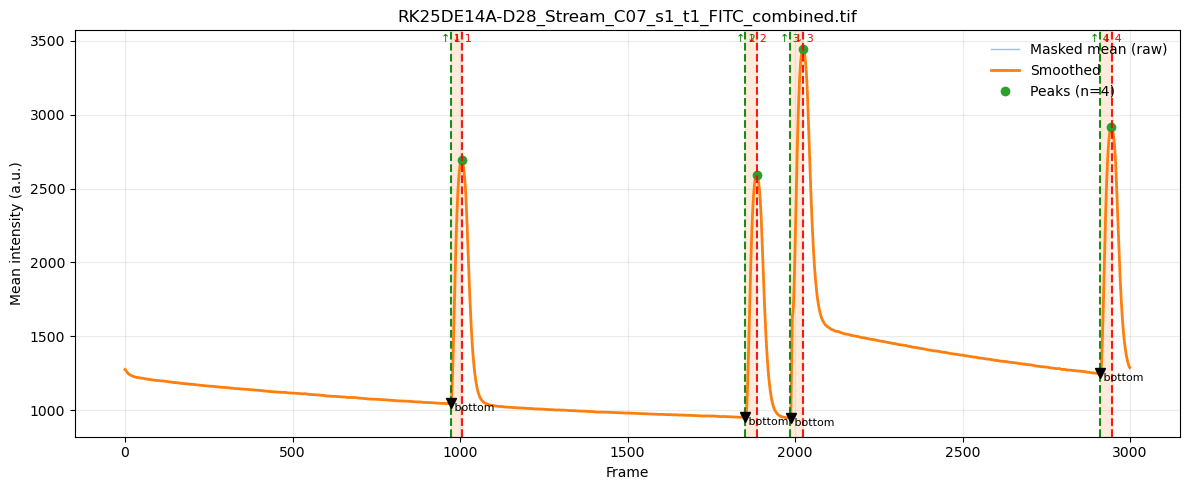

In [6]:
tif_files = sorted(glob.glob(os.path.join(base_dir, pattern)))
print(f"Found {len(tif_files)} combined TIFF files.")

for tif_path in tif_files:
    print(f"\n=== Processing {os.path.basename(tif_path)} ===")
    data = tiff.imread(tif_path).astype(np.float32)

    if data.ndim != 3:
        print("⚠️ Expected (T, H, W) format. Skipping.")
        continue

    # --- Get largest object ---
    mip = np.max(data, axis=0)
    base_mask = get_largest_object_mask(mip, min_size_px=min_size_px)
    if base_mask is None:
        print("❌ No object found. Skipping.")
        continue

    # --- Get dynamic region ---
    dyn_mask = get_dynamic_mask(data, base_mask, fc_thresh=min_fc)
    if not np.any(dyn_mask):
        print("⚠️ Dynamic mask empty. Using largest-object mask instead.")
        dyn_mask = base_mask

    # --- Build masked time series ---
    masked_ts = np.mean(data[:, dyn_mask], axis=1)

    # --- Detect peaks and events ---
    smoothed, peaks, events = detect_events(
        masked_ts,
        smooth_window=smooth_window,
        prominence_k=prominence_k,
        min_peak_dist=min_peak_dist,
    )

    print(f"Detected {len(events)} event(s): {events}")

    # after you compute `masked_ts`, `smoothed`, and `peaks`
    landmarks = compute_peak_landmarks_robust(
    smoothed,
    peaks,
    sg_window=11,      # try 9–21 depending on your frame rate/noise
    sg_poly=3,
    eps_factor=0.10,   # sensitivity of slope-change; increase if still late
    persist=3,         # require sustained sign for robustness
    search_pad=4       # avoids flat-top around the exact peak
)

plot_events_with_robust_landmarks(
    tif_path,
    time_signal=masked_ts,
    smoothed=smoothed,
    peaks=peaks,
    landmarks=landmarks,
    save_png=save_png,
    show=show_plots,
)

In [29]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from scipy.signal import find_peaks, savgol_filter
from skimage import measure, morphology, filters
import os

# === CONFIGURATION ===
tif_path = "/Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/RK25DE14A-D28_Stream_D19_s1_t1_FITC_combined.tif"

frame_pad_left = 20     # frames before slope-start
frame_pad_right = 20    # frames after peak
fold_threshold = 2.5    # dynamic pixel threshold
min_size_px = 500       # min object area for segmentation
save_png = True
show_plots = True

# === LOAD TIFF ===
data = tiff.imread(tif_path).astype(np.float32)
n_frames, H, W = data.shape
print(f"Loaded {os.path.basename(tif_path)} → shape: {data.shape}")

# === OUTPUT DIRECTORY ===
out_dir = os.path.join(os.path.dirname(tif_path), "event_signal_maps")
os.makedirs(out_dir, exist_ok=True)
print(f"Results will be saved in: {out_dir}")

Loaded RK25DE14A-D28_Stream_D19_s1_t1_FITC_combined.tif → shape: (3000, 1024, 1024)
Results will be saved in: /Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/event_signal_maps


Detected 4 events at peaks: [35, 716, 1526, 2026]


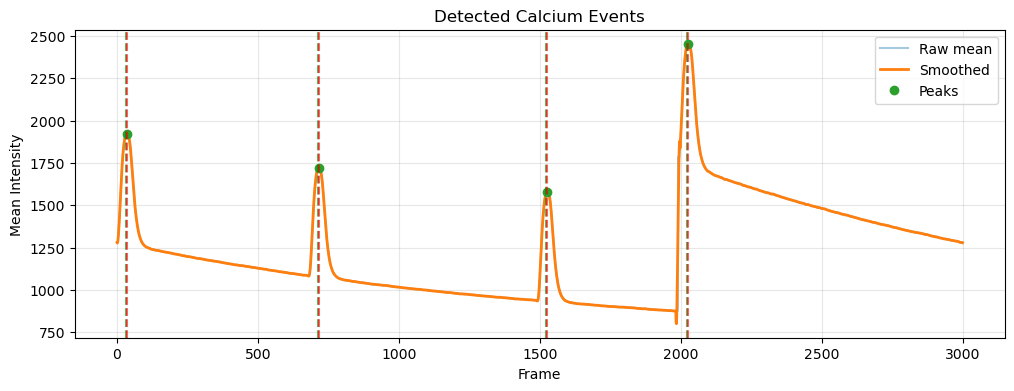

In [30]:
# --- compute masked mean signal (use full image mean for now) ---
trace = np.mean(data.reshape(n_frames, -1), axis=1)

# --- smooth ---
smoothed = savgol_filter(trace, window_length=15, polyorder=3)
std = np.std(smoothed)
peaks, _ = find_peaks(smoothed, prominence=1.5*std, distance=5)

# --- derive slope-based event windows ---
d1 = np.gradient(smoothed)
eps = 0.1 * np.std(d1)
persist = 3

landmarks = []
for p in peaks:
    # find rise start
    s = None
    for i in range(p-1, 0, -1):
        if np.all(d1[i:i+persist] > eps):
            s = i
            break
    if s is None: s = max(0, p-10)
    landmarks.append({"peak": int(p), "left": int(s)})

print(f"Detected {len(landmarks)} events at peaks:", [lm['peak'] for lm in landmarks])

# --- visualize ---
plt.figure(figsize=(12,4))
plt.plot(trace, alpha=0.4, label="Raw mean")
plt.plot(smoothed, lw=2, label="Smoothed")
plt.plot(peaks, smoothed[peaks], "o", label="Peaks")
for lm in landmarks:
    plt.axvline(lm["left"], color="green", ls="--", alpha=0.6)
    plt.axvline(lm["peak"], color="red", ls="--", alpha=0.6)
plt.legend(); plt.grid(alpha=0.3)
plt.title("Detected Calcium Events"); plt.xlabel("Frame"); plt.ylabel("Mean Intensity")
plt.show()

In [31]:
def process_signal_propagation(event_id, data_event, fold_threshold=2.5, min_size_px=500):
    """
    For a given event substack (frames, H, W):
      - Segment largest object from MIP
      - Keep pixels with ≥ fold_threshold× change
      - Compute frame when pixel reaches 75% of its local max
    Returns: mip, mask, frame_of_halfmax
    """
    mip = np.max(data_event, axis=0)

    # --- SEGMENT largest object ---
    thr = filters.threshold_otsu(mip)
    binary = mip > thr
    binary_filled = ndi.binary_fill_holes(binary)
    binary_clean = morphology.remove_small_objects(binary_filled, min_size=min_size_px)
    labels = measure.label(binary_clean)
    props = measure.regionprops(labels)
    if not props:
        print(f"⚠️ No object found for event {event_id}")
        return None, None, None
    largest_label = max(props, key=lambda x: x.area).label
    mask = ndi.binary_fill_holes(labels == largest_label)

    # --- DYNAMIC PIXELS ---
    min_intensity = np.min(data_event, axis=0)
    max_intensity = np.max(data_event, axis=0)
    fold_change = np.divide(max_intensity, np.maximum(min_intensity, 1e-6))
    change_mask = fold_change >= fold_threshold
    final_mask = mask & change_mask

    # --- FRAME OF 75% MAX ---
    half_max = 0.75 * max_intensity
    frame_of_halfmax = np.full(max_intensity.shape, np.nan, dtype=np.float32)
    valid_mask = final_mask & (max_intensity > 0)

    for f in range(data_event.shape[0]):
        frame_slice = data_event[f]
        hit_mask = (frame_slice >= half_max) & valid_mask & np.isnan(frame_of_halfmax)
        frame_of_halfmax[hit_mask] = f

    return mip, final_mask, frame_of_halfmax


=== Event 1: frames 11–55 ===
✅ Saved mask to /Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/event_signal_maps/RK25DE14A-D28_Stream_D19_s1_t1_FITC_combined_event1_mask.tif
✅ Saved frame map to /Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/event_signal_maps/RK25DE14A-D28_Stream_D19_s1_t1_FITC_combined_event1_frame75map.tif
💾 Saved visualization → /Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/event_signal_maps/RK25DE14A-D28_Stream_D19_s1_t1_FITC_combined_event1_map.png


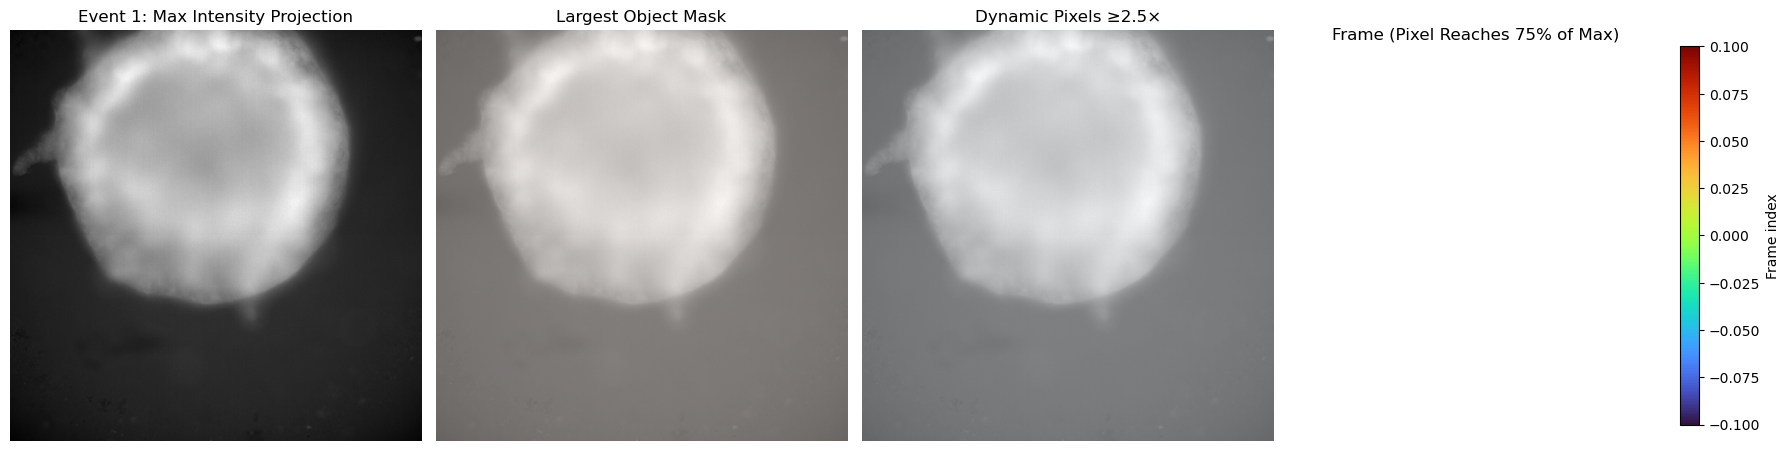


=== Event 2: frames 692–736 ===
✅ Saved mask to /Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/event_signal_maps/RK25DE14A-D28_Stream_D19_s1_t1_FITC_combined_event2_mask.tif
✅ Saved frame map to /Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/event_signal_maps/RK25DE14A-D28_Stream_D19_s1_t1_FITC_combined_event2_frame75map.tif
💾 Saved visualization → /Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/event_signal_maps/RK25DE14A-D28_Stream_D19_s1_t1_FITC_combined_event2_map.png


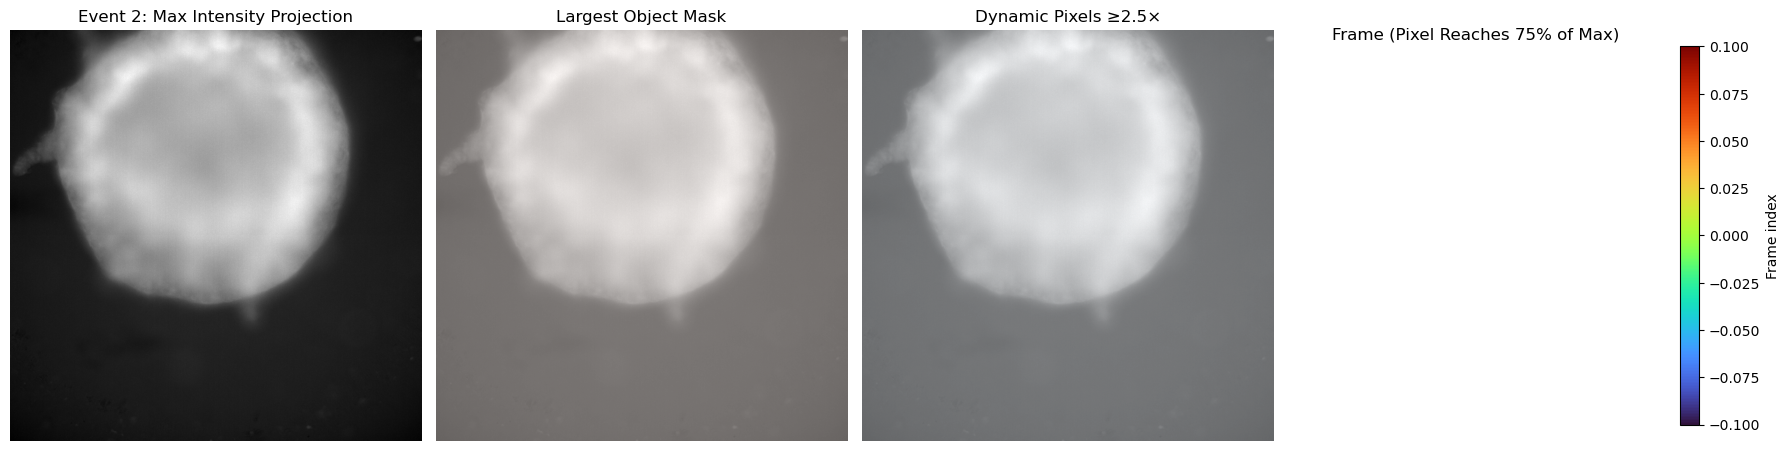


=== Event 3: frames 1503–1546 ===
✅ Saved mask to /Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/event_signal_maps/RK25DE14A-D28_Stream_D19_s1_t1_FITC_combined_event3_mask.tif
✅ Saved frame map to /Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/event_signal_maps/RK25DE14A-D28_Stream_D19_s1_t1_FITC_combined_event3_frame75map.tif
💾 Saved visualization → /Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/event_signal_maps/RK25DE14A-D28_Stream_D19_s1_t1_FITC_combined_event3_map.png


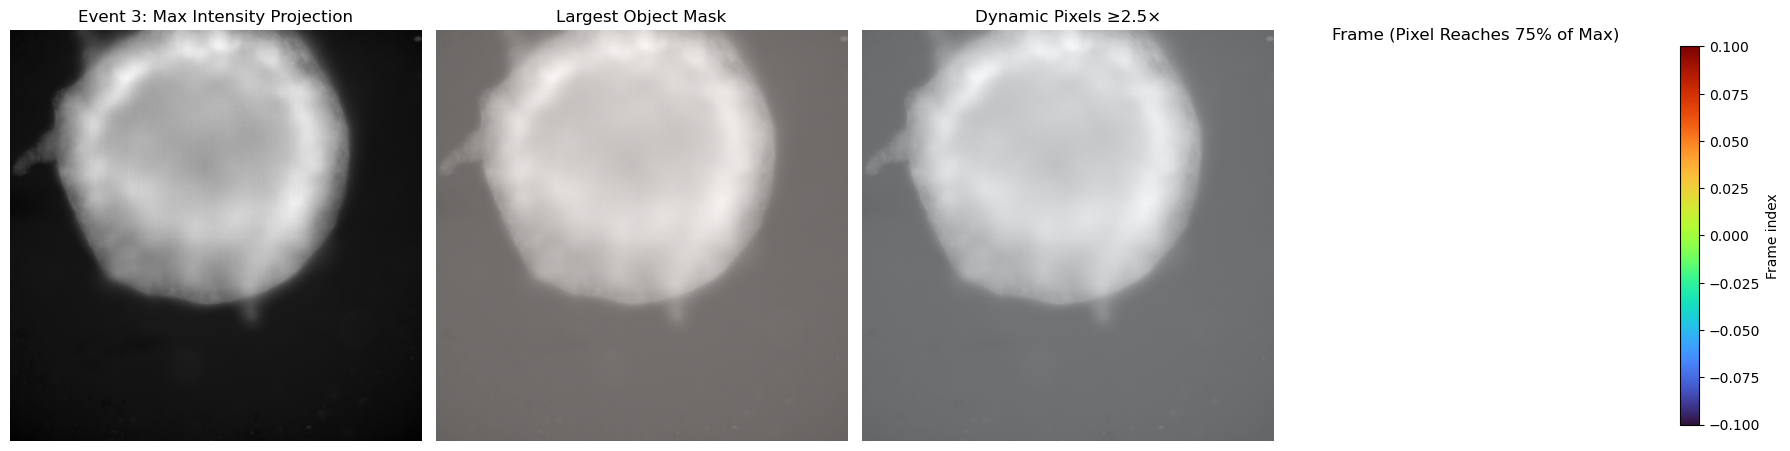


=== Event 4: frames 2002–2046 ===
✅ Saved mask to /Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/event_signal_maps/RK25DE14A-D28_Stream_D19_s1_t1_FITC_combined_event4_mask.tif
✅ Saved frame map to /Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/event_signal_maps/RK25DE14A-D28_Stream_D19_s1_t1_FITC_combined_event4_frame75map.tif
💾 Saved visualization → /Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/event_signal_maps/RK25DE14A-D28_Stream_D19_s1_t1_FITC_combined_event4_map.png


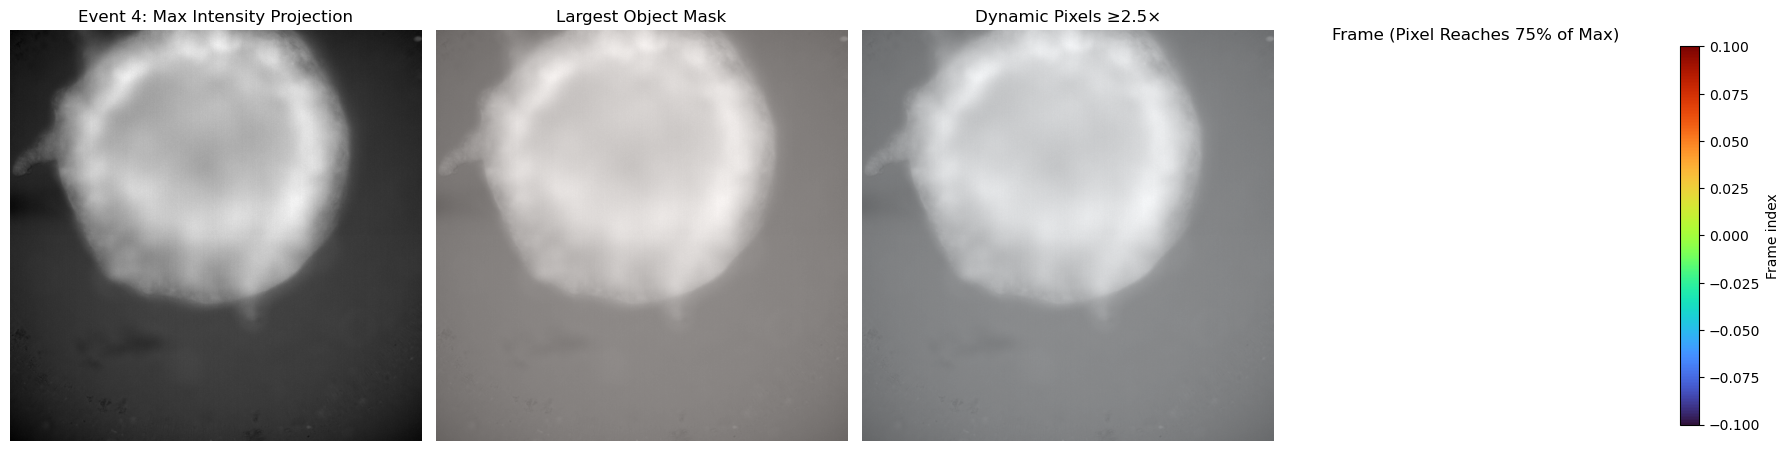

In [32]:
for i, ev in enumerate(landmarks, 1):
    start = max(ev["left"] - frame_pad_left, 0)
    end = min(ev["peak"] + frame_pad_right, n_frames)
    print(f"\n=== Event {i}: frames {start}–{end} ===")

    data_event = data[start:end]
    mip, mask, frame_map = process_signal_propagation(i, data_event, fold_threshold, min_size_px)
    if mip is None:
        continue

    # --- SAVE ---
    base_name = os.path.splitext(os.path.basename(tif_path))[0]
    mask_file = os.path.join(out_dir, f"{base_name}_event{i}_mask.tif")
    frame_file = os.path.join(out_dir, f"{base_name}_event{i}_frame75map.tif")

    tiff.imwrite(mask_file, mask.astype(np.uint8))
    tiff.imwrite(frame_file, np.nan_to_num(frame_map, nan=0).astype(np.float32))
    print(f"✅ Saved mask to {mask_file}")
    print(f"✅ Saved frame map to {frame_file}")

    # --- VISUALIZE ---
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    axes[0].imshow(mip, cmap="gray")
    axes[0].set_title(f"Event {i}: Max Intensity Projection")
    axes[0].axis("off")

    axes[1].imshow(mip, cmap="gray")
    axes[1].imshow(mask, cmap="Reds", alpha=0.4)
    axes[1].set_title("Largest Object Mask")
    axes[1].axis("off")

    axes[2].imshow(mip, cmap="gray")
    axes[2].imshow(mask, cmap="Blues", alpha=0.4)
    axes[2].set_title("Dynamic Pixels ≥2.5×")
    axes[2].axis("off")

    im = axes[3].imshow(frame_map, cmap="turbo")
    axes[3].set_title("Frame (Pixel Reaches 75% of Max)")
    axes[3].axis("off")
    fig.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04, label="Frame index")
    plt.tight_layout()

    if save_png:
        out_png = os.path.join(out_dir, f"{base_name}_event{i}_map.png")
        fig.savefig(out_png, dpi=200)
        print(f"💾 Saved visualization → {out_png}")

    if show_plots:
        plt.show()
    else:
        plt.close(fig)


--- Loading TIFF ---
Loaded RK25DE14B-D21_Stream_C07_s1_t1_FITC_combined.tif → shape: (3000, 1024, 1024)
Detected 3 events at peaks: [492, 1371, 2217]


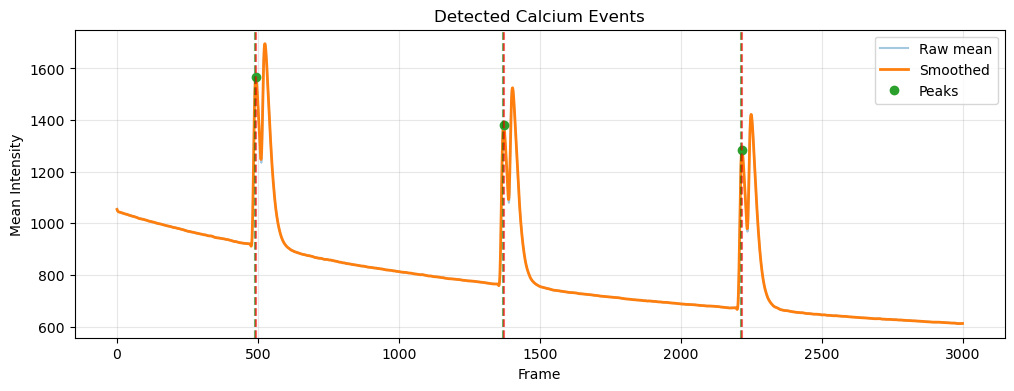


=== Event 1: frames 390–492 ===
   → Frame range (relative): 92–101
   → Frame range (absolute): 482–491
   → Mean propagation speed: 34.620 µm/s
💾 Saved visualization → /Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/event_signal_maps_fullpipeline/RK25DE14B-D21_Stream_C07_s1_t1_FITC_combined_event1_propagationSTD_speed.png


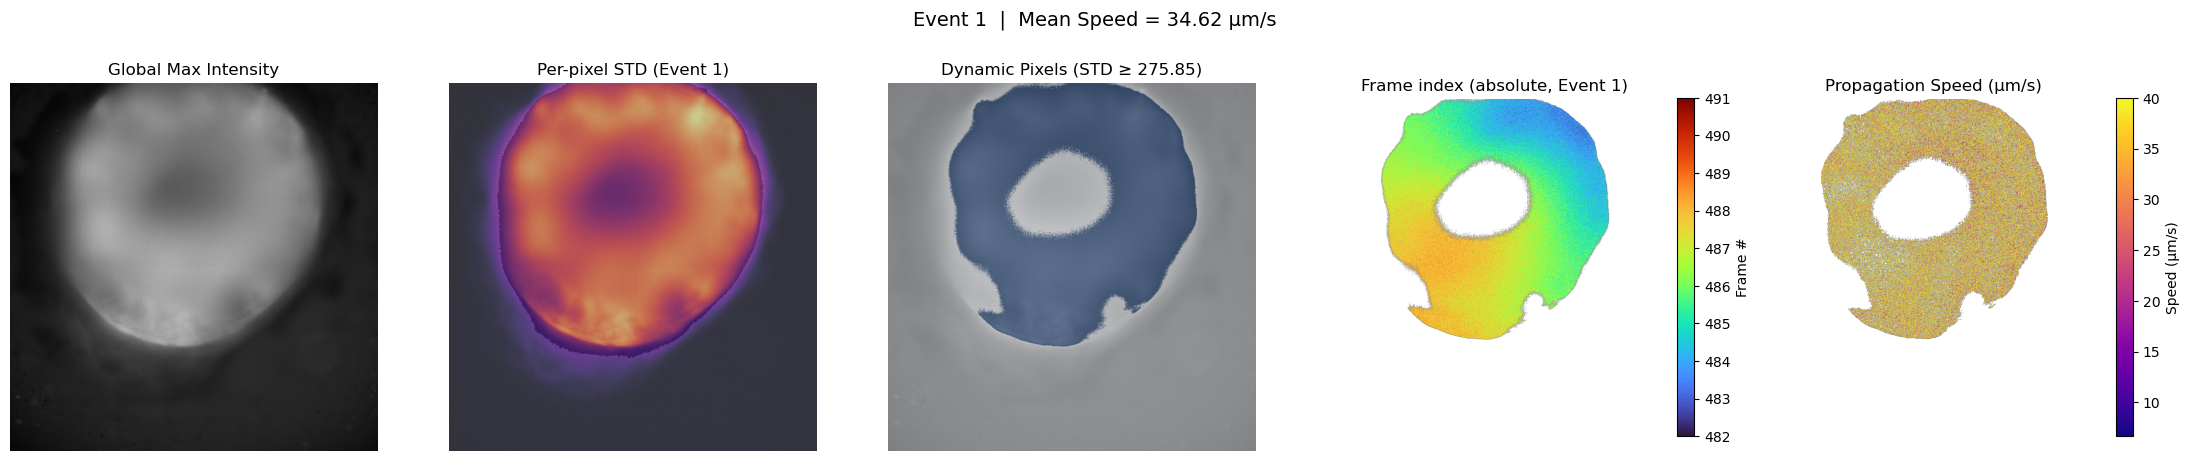


=== Event 2: frames 1269–1371 ===
   → Frame range (relative): 91–101
   → Frame range (absolute): 1360–1370
   → Mean propagation speed: 34.476 µm/s
💾 Saved visualization → /Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/event_signal_maps_fullpipeline/RK25DE14B-D21_Stream_C07_s1_t1_FITC_combined_event2_propagationSTD_speed.png


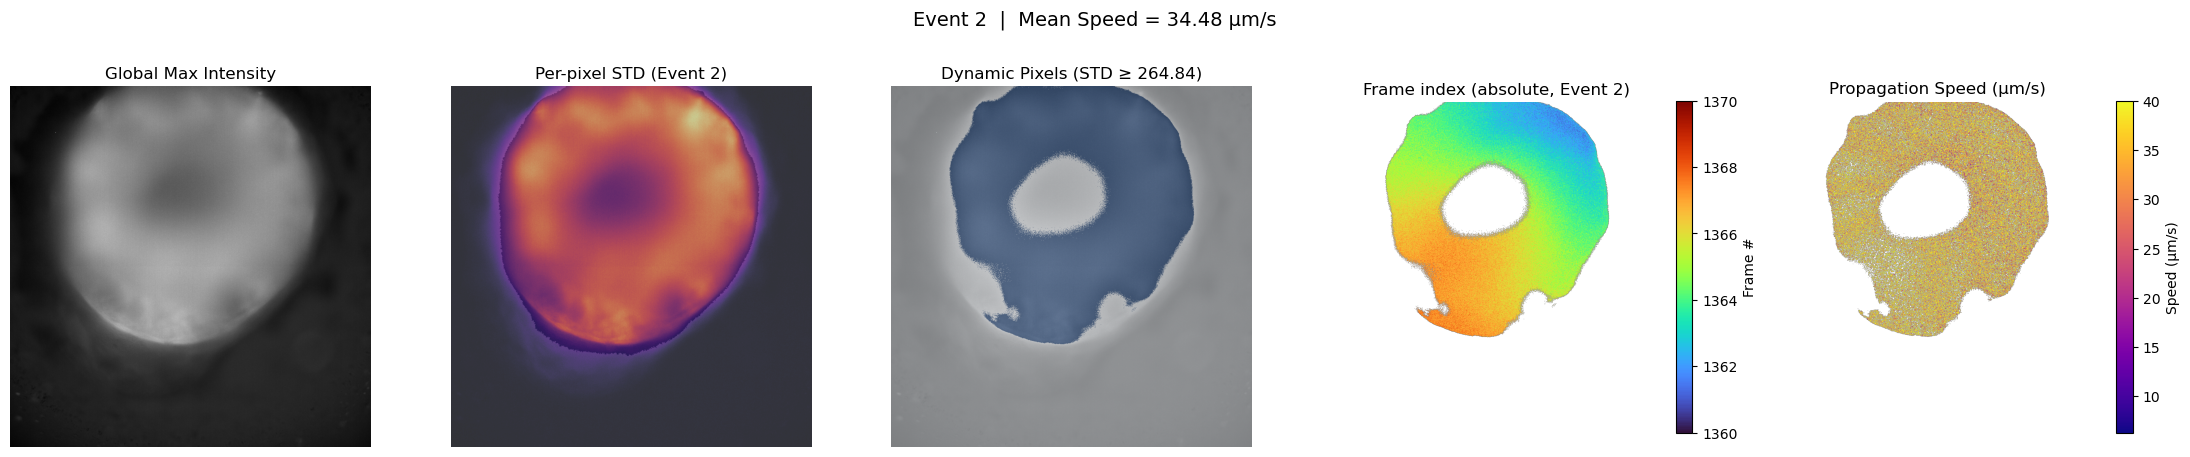


=== Event 3: frames 2114–2217 ===
   → Frame range (relative): 92–101
   → Frame range (absolute): 2206–2215
   → Mean propagation speed: 34.677 µm/s
💾 Saved visualization → /Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/event_signal_maps_fullpipeline/RK25DE14B-D21_Stream_C07_s1_t1_FITC_combined_event3_propagationSTD_speed.png


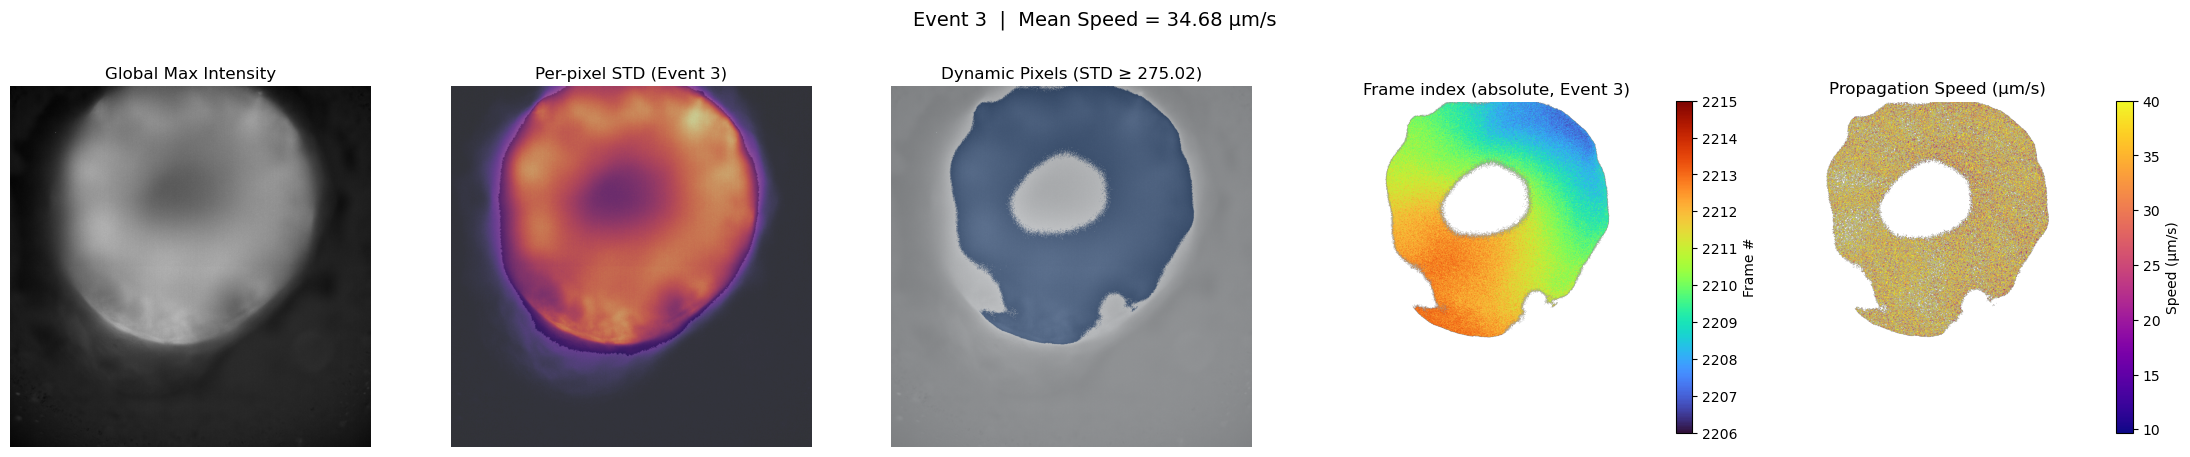


=== Event Duration Summary (difference = rel_max - rel_min) ===
Event  1: duration =    9 frames (0.45 s) | mean speed = 34.62 µm/s
Event  2: duration =   10 frames (0.50 s) | mean speed = 34.48 µm/s
Event  3: duration =    9 frames (0.45 s) | mean speed = 34.68 µm/s


In [3]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from scipy.signal import find_peaks, savgol_filter
from skimage import measure, morphology, filters
import os

# === CONFIGURATION ===
tif_path = '/Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined/RK25DE14B-D21_Stream_C07_s1_t1_FITC_combined.tif'
frame_pad_left = 100
frame_pad_right = 0
std_thresh_factor = -0.5         # STD threshold multiplier
min_size_px = 500
save_png = True
show_plots = True

# === OUTPUT DIRECTORY ===
out_dir = os.path.join(os.path.dirname(tif_path), "event_signal_maps_fullpipeline")
os.makedirs(out_dir, exist_ok=True)

# ---------------------------------------------------
# Helper 1️⃣ — Detect Events from Global Mean Trace
# ---------------------------------------------------
def detect_events(data, smooth_win=15, prominence_factor=1.5, min_distance=5, baseline_drop=0.75):
    """
    Detect calcium peaks from global intensity trace.
    Filters out closely spaced 'double peaks' that do not return
    to at least 75% of the previous peak's height.
    """
    # --- Compute mean trace and smooth ---
    mean_trace = np.mean(data.reshape(data.shape[0], -1), axis=1)
    smoothed = savgol_filter(mean_trace, window_length=smooth_win, polyorder=3)
    std = np.std(smoothed)

    # --- Initial peak detection ---
    peaks, properties = find_peaks(smoothed, prominence=prominence_factor * std, distance=min_distance)

    # --- Merge double peaks (require baseline drop) ---
    filtered_peaks = []
    if len(peaks) > 0:
        filtered_peaks.append(peaks[0])
        for i in range(1, len(peaks)):
            prev = filtered_peaks[-1]
            curr = peaks[i]

            # local min between peaks
            valley = np.min(smoothed[prev:curr])
            prev_height = smoothed[prev]
            curr_height = smoothed[curr]

            # compute threshold (75% of smaller peak)
            threshold = baseline_drop * min(prev_height, curr_height)

            # accept only if valley < threshold (baseline recovered)
            if valley < threshold:
                filtered_peaks.append(curr)

    peaks = np.array(filtered_peaks, dtype=int)

    # --- Compute derivative for slope starts ---
    d1 = np.gradient(smoothed)
    eps = 0.1 * np.std(d1)
    persist = 3

    landmarks = []
    for p in peaks:
        left = None
        for i in range(p - 1, 0, -1):
            if np.all(d1[i:i + persist] > eps):
                left = i
                break
        if left is None:
            left = max(0, p - 10)
        landmarks.append({"left": int(left), "peak": int(p)})

    return landmarks, mean_trace, smoothed, peaks

# ---------------------------------------------------
# Helper 2️⃣ — Segment Global Mask Once
# ---------------------------------------------------
def get_global_mask(data, min_size_px=500, relax=0.8):
    """Segment largest object in MIP once for all events."""
    mip = np.max(data, axis=0)
    mip_norm = (mip - np.min(mip)) / (np.max(mip) - np.min(mip) + 1e-6)
    thr = filters.threshold_otsu(mip_norm) * relax
    binary = mip_norm > thr
    filled = ndi.binary_fill_holes(binary)
    cleaned = morphology.remove_small_objects(filled, min_size=min_size_px)
    labels = measure.label(cleaned)
    props = measure.regionprops(labels)
    if not props:
        raise ValueError("❌ No objects found in segmentation.")
    largest_label = max(props, key=lambda x: x.area).label
    mask = ndi.binary_fill_holes(labels == largest_label)
    return mip_norm, mask

# ---------------------------------------------------
# Helper 3️⃣ — Per-Event STD-Based Dynamic Map
# ---------------------------------------------------
def analyze_event_std(event_data, global_mask, std_thresh_factor=0.0):
    """
    Compute dynamic pixel mask via per-pixel STD and frame when pixel reaches
    50% of its (max - min) range within the event window.
    """
    # --- compute per-pixel temporal statistics ---
    pixel_std = np.std(event_data, axis=0)
    pixel_min = np.min(event_data, axis=0)
    pixel_max = np.max(event_data, axis=0)

    # --- threshold for dynamic pixels (based on STD) ---
    masked_std = pixel_std[global_mask]
    mean_std = np.mean(masked_std)
    std_std = np.std(masked_std)
    threshold = mean_std + std_thresh_factor * std_std

    dynamic_mask = global_mask & (pixel_std >= threshold)

    # --- compute per-pixel half-max frame relative to its own baseline ---
    frame_map = np.full_like(pixel_max, np.nan, dtype=np.float32)
    valid_mask = dynamic_mask & (pixel_max > pixel_min + 1e-6)

    # relative half-max = baseline + 0.5 * (max - min)
    half_level = pixel_min + 0.75 * (pixel_max - pixel_min)

    # iterate through time to assign first frame reaching half-max
    for f in range(event_data.shape[0]):
        frame_slice = event_data[f]
        hit_mask = (frame_slice >= half_level) & valid_mask & np.isnan(frame_map)
        frame_map[hit_mask] = f

    return pixel_std, dynamic_mask, frame_map, threshold

# ---------------------------------------------------
# MAIN PIPELINE
# ---------------------------------------------------
print(f"\n--- Loading TIFF ---")
data = tiff.imread(tif_path).astype(np.float32)
n_frames, H, W = data.shape
print(f"Loaded {os.path.basename(tif_path)} → shape: {data.shape}")

# --- Detect events ---
landmarks, mean_trace, smoothed, peaks = detect_events(data)
print(f"Detected {len(landmarks)} events at peaks:", [lm['peak'] for lm in landmarks])

# --- Plot detected events ---
plt.figure(figsize=(12, 4))
plt.plot(mean_trace, alpha=0.4, label="Raw mean")
plt.plot(smoothed, lw=2, label="Smoothed")
plt.plot(peaks, smoothed[peaks], "o", label="Peaks")
for lm in landmarks:
    plt.axvline(lm["left"], color="green", ls="--", alpha=0.6)
    plt.axvline(lm["peak"], color="red", ls="--", alpha=0.6)
plt.legend(); plt.grid(alpha=0.3)
plt.title("Detected Calcium Events"); plt.xlabel("Frame"); plt.ylabel("Mean Intensity")
plt.show()

# --- Get global mask ---
#print("\n--- Global segmentation ---")
mip_norm, global_mask = get_global_mask(data, min_size_px=min_size_px, relax=0.8)
#print(f"✅ Global mask established, area = {np.sum(global_mask)} px")

#plt.figure(figsize=(6,6))
#plt.imshow(mip_norm, cmap="gray")
#plt.imshow(global_mask, cmap="Reds", alpha=0.4)
#plt.title("Global Mask (largest object)")
#plt.axis("off")
#plt.show()

# Save mask
mask_file = os.path.join(out_dir, os.path.splitext(os.path.basename(tif_path))[0] + "_globalmask.tif")
tiff.imwrite(mask_file, global_mask.astype(np.uint8))

from scipy import ndimage as ndi

# Set pixel size (µm per pixel) and frame rate (frames per second)
pixel_size_um = 1.0    # adjust to your microscope scale
frame_rate = 20.0      # e.g. 20 frames/s

event_results = []

for i, ev in enumerate(landmarks, 1):
    start = max(ev["left"] - frame_pad_left, 0)
    end = min(ev["peak"] + frame_pad_right, n_frames)
    print(f"\n=== Event {i}: frames {start}–{end} ===")

    event_data = data[start:end]
    pixel_std, dynamic_mask, frame_map, threshold = analyze_event_std(
        event_data, global_mask, std_thresh_factor
    )

    # --- Activation frame statistics ---
    valid_frames = frame_map[np.isfinite(frame_map)]
    if valid_frames.size > 0:
        rel_min, rel_max = int(np.nanmin(valid_frames)), int(np.nanmax(valid_frames))
        abs_min, abs_max = start + rel_min, start + rel_max
    else:
        rel_min = rel_max = abs_min = abs_max = np.nan

    # --- Propagation speed estimation ---
    # Compute spatial gradients of activation time
    grad_y, grad_x = np.gradient(frame_map)
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)

    # Avoid division by zero and restrict to valid dynamic pixels
    speed_map = np.zeros_like(frame_map)
    with np.errstate(divide='ignore', invalid='ignore'):
        speed_map = (pixel_size_um / grad_mag) * frame_rate
        speed_map[~np.isfinite(speed_map)] = np.nan

    # Mask speed map to valid dynamic pixels only
    speed_map[~dynamic_mask] = np.nan

    mean_speed = np.nanmean(speed_map)
    median_speed = np.nanmedian(speed_map)
    std_speed = np.nanstd(speed_map)

    print(f"   → Frame range (relative): {rel_min}–{rel_max}")
    print(f"   → Frame range (absolute): {abs_min}–{abs_max}")
    print(f"   → Mean propagation speed: {mean_speed:.3f} µm/s")

    # --- Store all results ---
    event_results.append({
        "event_id": i,
        "start_frame": start,
        "peak_frame": ev["peak"],
        "end_frame": end,
        "threshold": threshold,
        "dynamic_pixel_count": int(np.sum(dynamic_mask)),
        "frame_range_rel": (rel_min, rel_max),
        "frame_range_abs": (abs_min, abs_max),
        "mean_speed_um_s": mean_speed,
        "median_speed_um_s": median_speed,
        "std_speed_um_s": std_speed,
        "frame_map": frame_map,
        "speed_map": speed_map,
        "difference": rel_max - rel_min,
    })

    # --- Save results ---
    base = os.path.splitext(os.path.basename(tif_path))[0]
    dyn_path = os.path.join(out_dir, f"{base}_event{i}_dynamicmaskSTD.tif")
    frame_path = os.path.join(out_dir, f"{base}_event{i}_frame50mapSTD.tif")
    speed_path = os.path.join(out_dir, f"{base}_event{i}_speedmap.tif")

    tiff.imwrite(dyn_path, dynamic_mask.astype(np.uint8))
    tiff.imwrite(frame_path, np.nan_to_num(frame_map, nan=0).astype(np.float32))
    tiff.imwrite(speed_path, np.nan_to_num(speed_map, nan=0).astype(np.float32))

    # --- Visualization ---
    fig, axes = plt.subplots(1, 5, figsize=(22, 5))
    axes[0].imshow(mip_norm, cmap="gray")
    axes[0].set_title("Global Max Intensity")
    axes[0].axis("off")

    axes[1].imshow(pixel_std, cmap="magma")
    axes[1].imshow(global_mask, cmap="Greens", alpha=0.2)
    axes[1].set_title(f"Per-pixel STD (Event {i})")
    axes[1].axis("off")

    axes[2].imshow(mip_norm, cmap="gray")
    axes[2].imshow(dynamic_mask, cmap="Blues", alpha=0.5)
    axes[2].set_title(f"Dynamic Pixels (STD ≥ {threshold:.2f})")
    axes[2].axis("off")

    im3 = axes[3].imshow(frame_map + start, cmap="turbo")
    axes[3].set_title(f"Frame index (absolute, Event {i})")
    axes[3].axis("off")
    fig.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04, label="Frame #")

    im4 = axes[4].imshow(speed_map, cmap="plasma")
    axes[4].set_title("Propagation Speed (µm/s)")
    axes[4].axis("off")
    fig.colorbar(im4, ax=axes[4], fraction=0.046, pad=0.04, label="Speed (µm/s)")

    plt.suptitle(f"Event {i}  |  Mean Speed = {mean_speed:.2f} µm/s", fontsize=14)
    plt.tight_layout()
    if save_png:
        png_path = os.path.join(out_dir, f"{base}_event{i}_propagationSTD_speed.png")
        fig.savefig(png_path, dpi=200)
        print(f"💾 Saved visualization → {png_path}")

    if show_plots:
        plt.show()
    else:
        plt.close(fig)


print("\n=== Event Duration Summary (difference = rel_max - rel_min) ===")
for ev in event_results:
    diff = ev["difference"]
    print(f"Event {ev['event_id']:>2}: duration = {diff:>4} frames "
          f"({diff / frame_rate:.2f} s) | mean speed = {ev['mean_speed_um_s']:.2f} µm/s")

In [1]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from scipy.signal import find_peaks, savgol_filter
from skimage import measure, morphology, filters
import pandas as pd
import os

# ==============================
# CONFIGURATION
# ==============================
#input_dir = "/Users/lokesh.pimpale/Desktop/work_dir/RK/untitled folder/combined"

input_dir = "/Volumes/volume2/2025/D-Disease Modeling Team/E-PKP2/2025/00_ToAnalyze/stream/GFP/RK25DE14B-D21_GFP/22276/combined"
process_all = True      # 👈 toggle between all files or single
single_tif_name = "RK25DE14A-D28_Stream_C09_s1_t1_FITC_combined.tif"

frame_pad_left = 100
frame_pad_right = 100
std_thresh_factor = -0.5
min_size_px = 500
pixel_size_um = 1.0
frame_rate = 20.0
save_png = False
show_plots = False

# ==============================
# FUNCTIONS
# ==============================

def detect_events(data, smooth_win=15, prominence_factor=1.5, min_distance=5):
    """Detect calcium peaks from global intensity trace."""
    mean_trace = np.mean(data.reshape(data.shape[0], -1), axis=1)
    smoothed = savgol_filter(mean_trace, window_length=smooth_win, polyorder=3)
    std = np.std(smoothed)
    peaks, _ = find_peaks(smoothed, prominence=prominence_factor * std, distance=min_distance)

    d1 = np.gradient(smoothed)
    eps = 0.1 * np.std(d1)
    persist = 3
    landmarks = []
    for p in peaks:
        left = None
        for i in range(p - 1, 0, -1):
            if np.all(d1[i:i + persist] > eps):
                left = i
                break
        if left is None:
            left = max(0, p - 10)
        landmarks.append({"left": int(left), "peak": int(p)})
    return landmarks, mean_trace, smoothed, peaks


def get_global_mask(data, min_size_px=500, relax=0.8):
    """Segment largest object in MIP once for all events."""
    mip = np.max(data, axis=0)
    mip_norm = (mip - np.min(mip)) / (np.max(mip) - np.min(mip) + 1e-6)
    thr = filters.threshold_otsu(mip_norm) * relax
    binary = mip_norm > thr
    filled = ndi.binary_fill_holes(binary)
    cleaned = morphology.remove_small_objects(filled, min_size=min_size_px)
    labels = measure.label(cleaned)
    props = measure.regionprops(labels)
    if not props:
        raise ValueError("❌ No objects found in segmentation.")
    largest_label = max(props, key=lambda x: x.area).label
    mask = ndi.binary_fill_holes(labels == largest_label)
    return mip_norm, mask


def analyze_event_std(event_data, global_mask, std_thresh_factor=0.0):
    """Compute dynamic pixel mask via per-pixel STD and half-max frame map."""
    pixel_std = np.std(event_data, axis=0)
    pixel_min = np.min(event_data, axis=0)
    pixel_max = np.max(event_data, axis=0)

    masked_std = pixel_std[global_mask]
    mean_std = np.mean(masked_std)
    std_std = np.std(masked_std)
    threshold = mean_std + std_thresh_factor * std_std
    dynamic_mask = global_mask & (pixel_std >= threshold)

    frame_map = np.full_like(pixel_max, np.nan, dtype=np.float32)
    valid_mask = dynamic_mask & (pixel_max > pixel_min + 1e-6)
    half_level = pixel_min + 0.75 * (pixel_max - pixel_min)
    for f in range(event_data.shape[0]):
        frame_slice = event_data[f]
        hit_mask = (frame_slice >= half_level) & valid_mask & np.isnan(frame_map)
        frame_map[hit_mask] = f
    return pixel_std, dynamic_mask, frame_map, threshold


def analyze_tif(tif_path):
    """Full pipeline for a single TIFF file."""
    print(f"\n🔹 Analyzing {os.path.basename(tif_path)}")

    # Load data
    data = tiff.imread(tif_path).astype(np.float32)
    n_frames, H, W = data.shape

    # Detect events
    landmarks, mean_trace, smoothed, peaks = detect_events(data)
    if not landmarks:
        print("⚠️ No events detected — skipping file.")
        return []

    # Global mask
    mip_norm, global_mask = get_global_mask(data, min_size_px=min_size_px)
    mask_file = os.path.splitext(tif_path)[0] + "_globalmask.tif"
    tiff.imwrite(mask_file, global_mask.astype(np.uint8))

    # Analyze each event
    event_results = []
    for i, ev in enumerate(landmarks, 1):
        start = max(ev["left"] - frame_pad_left, 0)
        end = min(ev["peak"] + frame_pad_right, n_frames)
        event_data = data[start:end]

        pixel_std, dynamic_mask, frame_map, threshold = analyze_event_std(event_data, global_mask, std_thresh_factor)

        valid_frames = frame_map[np.isfinite(frame_map)]
        if valid_frames.size > 0:
            rel_min, rel_max = int(np.nanmin(valid_frames)), int(np.nanmax(valid_frames))
            abs_min, abs_max = start + rel_min, start + rel_max
        else:
            rel_min = rel_max = abs_min = abs_max = np.nan

        # --- Propagation speed ---
        grad_y, grad_x = np.gradient(frame_map)
        grad_mag = np.sqrt(grad_x**2 + grad_y**2)
        with np.errstate(divide='ignore', invalid='ignore'):
            speed_map = (pixel_size_um / grad_mag) * frame_rate
            speed_map[~np.isfinite(speed_map)] = np.nan
        speed_map[~dynamic_mask] = np.nan

        mean_speed = np.nanmean(speed_map)
        median_speed = np.nanmedian(speed_map)
        std_speed = np.nanstd(speed_map)

        event_results.append({
            "file": os.path.basename(tif_path),
            "event_id": i,
            "start_frame": start,
            "peak_frame": ev["peak"],
            "end_frame": end,
            "threshold": threshold,
            "dynamic_pixel_count": int(np.sum(dynamic_mask)),
            "frame_range_rel": (rel_min, rel_max),
            "frame_range_abs": (abs_min, abs_max),
            "mean_speed_um_s": mean_speed,
            "median_speed_um_s": median_speed,
            "std_speed_um_s": std_speed,
            "difference": rel_max - rel_min,
        })

        print(f"   → Event {i}: Δ = {rel_max - rel_min} frames ({(rel_max - rel_min)/frame_rate:.2f}s), "
              f"mean speed = {mean_speed:.2f} µm/s")

    return event_results


# ==============================
# MAIN RUN
# ==============================
if process_all:
    tif_files = sorted([os.path.join(input_dir, f)
                        for f in os.listdir(input_dir)
                        if f.endswith("_combined.tif")])
else:
    tif_files = [os.path.join(input_dir, single_tif_name)]

all_results = []
for tif_path in tif_files:
    all_results.extend(analyze_tif(tif_path))

# --- Export summary CSV ---
if all_results:
    df = pd.DataFrame(all_results)
    csv_path = os.path.join(input_dir, "CalciumEventSummary.csv")
    df.to_csv(csv_path, index=False)
    print(f"\n✅ Exported summary CSV: {csv_path}")
    print(df[["file", "event_id", "difference", "mean_speed_um_s"]])
else:
    print("\n⚠️ No events processed.")

TimeoutError: [Errno 60] Operation timed out: '/Volumes/volume2/2025/D-Disease Modeling Team/E-PKP2/2025/00_ToAnalyze/stream/GFP/RK25DE14B-D21_GFP/22276/combined'


🔹 Analyzing RK25DE14B-D21_Stream_C07_s1_t1_FITC_combined.tif
📈 Saved trace plot → /Volumes/volume2/2025/D-Disease Modeling Team/E-PKP2/2025/00_ToAnalyze/stream/GFP/RK25DE14B-D21_GFP/22276/combined/RK25DE14B-D21_Stream_C07_s1_t1_FITC_combined/RK25DE14B-D21_Stream_C07_s1_t1_FITC_combined_event_trace.png
💾 Saved event plot → /Volumes/volume2/2025/D-Disease Modeling Team/E-PKP2/2025/00_ToAnalyze/stream/GFP/RK25DE14B-D21_GFP/22276/combined/RK25DE14B-D21_Stream_C07_s1_t1_FITC_combined/RK25DE14B-D21_Stream_C07_s1_t1_FITC_combined_event1_summary.png
💾 Saved event plot → /Volumes/volume2/2025/D-Disease Modeling Team/E-PKP2/2025/00_ToAnalyze/stream/GFP/RK25DE14B-D21_GFP/22276/combined/RK25DE14B-D21_Stream_C07_s1_t1_FITC_combined/RK25DE14B-D21_Stream_C07_s1_t1_FITC_combined_event2_summary.png
💾 Saved event plot → /Volumes/volume2/2025/D-Disease Modeling Team/E-PKP2/2025/00_ToAnalyze/stream/GFP/RK25DE14B-D21_GFP/22276/combined/RK25DE14B-D21_Stream_C07_s1_t1_FITC_combined/RK25DE14B-D21_Stream_C07_